In [1]:
import wandb
import sys
import matplotlib.pyplot as plt
import scprep
import pandas as pd
sys.path.append('../src/')
from evaluate import get_results
from omegaconf import OmegaConf

In [2]:
# Initialize wandb (replace 'your_entity' and 'your_project' with your specific details)
wandb.login()
api = wandb.Api()

# Specify your entity, project, and sweep ID
entity = "xingzhis"
project = "dmae"
sweep_id = 'gbfsbi1b'

# Fetch the sweep
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")

run_ids = [run.id for run in sweep.runs]

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: xingzhis. Use `wandb login --relogin` to force relogin


In [3]:
summary_list, config_list, name_list, id_list = [], [], [], []
for run in sweep.runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        OmegaConf.create(run.config))

    # .name is the human-readable name of the run.
    name_list.append(run.name)
    id_list.append(run.id)

runs_df = pd.DataFrame({
    "id": id_list,
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

In [4]:
runs_df['data'] = runs_df['config'].apply(lambda x: x.data.name)
runs_df['dropout'] = runs_df['config'].apply(lambda x: x.model.dropout)
runs_df['batch_norm'] = runs_df['config'].apply(lambda x: x.model.batch_norm)
runs_df['weight_decay'] = runs_df['config'].apply(lambda x: x.model.weight_decay)
runs_df['dist_mse_decay'] = runs_df['config'].apply(lambda x: x.model.dist_mse_decay)
runs_df['cycle_weight'] = runs_df['config'].apply(lambda x: x.model.cycle_weight)
runs_df['cycle_dist_weight'] = runs_df['config'].apply(lambda x: x.model.cycle_dist_weight)
runs_df['train/dist_accuracy_epoch'] = runs_df['summary'].apply(lambda x: x['train/dist_accuracy_epoch'])
runs_df['validation/dist_accuracy'] = runs_df['summary'].apply(lambda x: x['validation/dist_accuracy'])

In [5]:
baseline_id = (runs_df['data'] == 'sea_ad_gaba') & \
              (runs_df['dropout'] == 0) & \
              (runs_df['batch_norm'] == False) & \
              (runs_df['weight_decay'] == 0) & \
              (runs_df['dist_mse_decay'] == 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [6]:
runs_df[baseline_id]

id                                            summary  \
323  qye7vqex  {'epoch': 37, 'Comparison Plot Latent': {'sha2...   

                                                config             name  \
323  [data, path, model, logger, model.lr, training...  sleek-sweep-109   

            data  dropout  batch_norm  weight_decay  dist_mse_decay  \
323  sea_ad_gaba      0.0       False           0.0             0.0   

     cycle_weight  cycle_dist_weight  train/dist_accuracy_epoch  \
323             0                  0                   0.827488   

     validation/dist_accuracy  
323                  0.805595

In [7]:
baseline_run_id = runs_df[baseline_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [8]:
regularize_id = (runs_df['data'] == 'sea_ad_gaba') & \
              (runs_df['dropout'] == 0.2) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] == 0.00001) & \
              (runs_df['dist_mse_decay'] == 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [9]:
runs_df[regularize_id]

id                                            summary  \
416  69m4j7g3  {'_timestamp': 1707706122.0865157, 'trainer/gl...   

                                                config           name  \
416  [data, path, model, logger, model.lr, training...  light-sweep-9   

            data  dropout  batch_norm  weight_decay  dist_mse_decay  \
416  sea_ad_gaba      0.2        True       0.00001             0.0   

     cycle_weight  cycle_dist_weight  train/dist_accuracy_epoch  \
416             0                  0                   0.771117   

     validation/dist_accuracy  
416                  0.808684

In [10]:
regularize_run_id = runs_df[regularize_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [11]:
mse_decay_id = (runs_df['data'] == 'sea_ad_gaba') & \
              (runs_df['dropout'] != 0) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] != 0) & \
              (runs_df['dist_mse_decay'] != 0) & \
              (runs_df['cycle_weight'] == 0) & \
              (runs_df['cycle_dist_weight'] == 0)

In [12]:
runs_df[mse_decay_id].sort_values('validation/dist_accuracy', ascending=False).head()

id                                            summary  \
404  1kue5egm  {'_runtime': 5534.26611495018, 'val_loss': 255...   
410  j87a5m1y  {'_timestamp': 1707705256.4394865, 'train_loss...   
413  ll0dqw1j  {'Comparison Plot Latent': {'path': 'media/plo...   
423  vf2jwez7  {'train_loss_epoch': 616.548095703125, 'valida...   
412  l2y1h8lf  {'validation/dist_loss': 384.7391052246094, 'v...   

                                                config                name  \
404  [data, path, model, logger, model.lr, training...      crisp-sweep-26   
410  [data, path, model, logger, model.lr, training...     absurd-sweep-27   
413  [data, path, model, logger, model.lr, training...  resilient-sweep-18   
423  [data, path, model, logger, model.lr, training...     sweepy-sweep-17   
412  [data, path, model, logger, model.lr, training...      misty-sweep-24   

            data  dropout  batch_norm  weight_decay  dist_mse_decay  \
404  sea_ad_gaba      0.2        True       0.00010             0.5   
410  sea_ad_gaba      0.2        True       0.00001             0.5   
413  sea_ad_gaba      0.2        True       0.00001             0.2   
423  sea_ad_gaba      0.2        True       0.00010             0.2   
412  sea_ad_gaba      0.5        True       0.00001             0.5   

     cycle_weight  cycle_dist_weight  train/dist_accuracy_epoch  \
404             0                  0                   0.780525   
410             0                  0                   0.781585   
413             0                  0                   0.777099   
423             0                  0                   0.779755   
412             0                  0                   0.667433   

     validation/dist_accuracy  
404                  0.820669  
410                  0.820648  
413                  0.813789  
423                  0.813485  
412                  0.788262

In [13]:
mse_decay_run_id = runs_df[mse_decay_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [38]:
cycle_id = (runs_df['data'] == 'sea_ad_gaba') & \
              (runs_df['dropout'] != 0) & \
              (runs_df['batch_norm'] == True) & \
              (runs_df['weight_decay'] != 0) & \
              (runs_df['dist_mse_decay'] != 0) & \
              ((runs_df['cycle_weight'] != 0) | \
              (runs_df['cycle_dist_weight'] != 0))

In [39]:
runs_df[cycle_id].sort_values("validation/dist_accuracy", ascending=False).head()

id                                            summary  \
325  s9i45o5o  {'train_loss_step': 830.7284545898438, 'Compar...   
324  m0x5gc4m  {'validation/reconstr_loss': 1.874577760696411...   
351  8o1lfd6z  {'train_loss_step': 628.8072509765625, 'train_...   
352  5zsp9p3b  {'epoch': 16, '_runtime': 1578.62336063385, 'd...   
376  hyrikqvj  {'_wandb': {'runtime': 1476}, 'distance_distor...   

                                                config               name  \
325  [data, path, model, logger, model.lr, training...    smart-sweep-107   
324  [data, path, model, logger, model.lr, training...  silvery-sweep-108   
351  [data, path, model, logger, model.lr, training...   scarlet-sweep-81   
352  [data, path, model, logger, model.lr, training...  youthful-sweep-80   
376  [data, path, model, logger, model.lr, training...   stellar-sweep-53   

            data  dropout  batch_norm  weight_decay  dist_mse_decay  \
325  sea_ad_gaba      0.2        True       0.00010             0.5   
324  sea_ad_gaba      0.2        True       0.00001             0.5   
351  sea_ad_gaba      0.2        True       0.00001             0.5   
352  sea_ad_gaba      0.2        True       0.00010             0.5   
376  sea_ad_gaba      0.2        True       0.00010             0.5   

     cycle_weight  cycle_dist_weight  train/dist_accuracy_epoch  \
325             1                  1                   0.780199   
324             1                  1                   0.781017   
351             0                  1                   0.779763   
352             0                  1                   0.782155   
376             1                  0                   0.780622   

     validation/dist_accuracy  
325                  0.817623  
324                  0.817473  
351                  0.817226  
352                  0.816040  
376                  0.815590

In [40]:
cycle_run_id = runs_df[cycle_id].sort_values('validation/dist_accuracy', ascending=False)['id'].iloc[0]

In [41]:
names_list = ['baseline', '+regularization', '+dist MSE decay', '+cycle loss']
run_ids_list = [baseline_run_id, regularize_run_id, mse_decay_run_id, cycle_run_id]
train_accs_list = [runs_df[runs_df['id'] == i]['train/dist_accuracy_epoch'].iloc[0] for i in run_ids_list]
valid_accs_list = [runs_df[runs_df['id'] == i]['validation/dist_accuracy'].iloc[0] for i in run_ids_list]

In [42]:
res_df = pd.DataFrame({
    'Name': names_list,
    'Run ID': run_ids_list,
    'Training Accuracy': train_accs_list,
    'Validation Accuracy': valid_accs_list
})


In [43]:
res_df

Name    Run ID  Training Accuracy  Validation Accuracy
0         baseline  qye7vqex           0.827488             0.805595
1  +regularization  69m4j7g3           0.771117             0.808684
2  +dist MSE decay  1kue5egm           0.780525             0.820669
3      +cycle loss  s9i45o5o           0.780199             0.817623

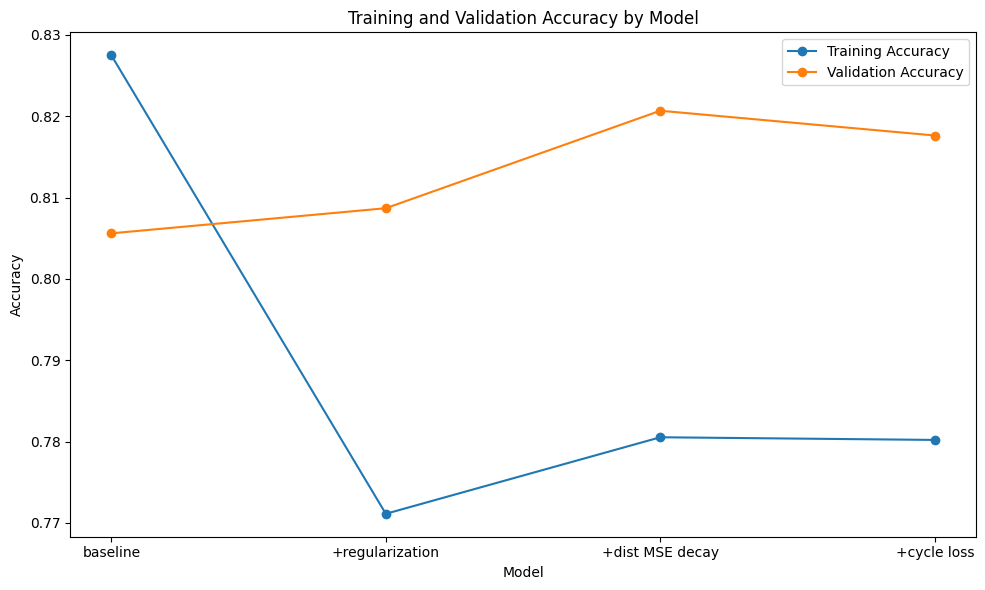

In [44]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Training and Validation Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:
res_list = []
for name, run_id in zip(res_df['Name'], res_df['Run ID']):
    run = api.run(f"{entity}/{project}/{run_id}")
    res, plots, cfg = get_results(run)
    res_list.append(
        dict(
            name=name,
            run_id=run_id,
            res=res,
            plots=plots,
            cfg=cfg
        )
    )

In [46]:
test_accs_list = [1 - res['res']['dist_mape_test_test'] for res in res_list]

In [47]:
test_accs_list

[0.5637858675557976,
 0.6928651040126919,
 0.7049404700705968,
 0.7091695357548637]

In [48]:
overall_accs_list = [1 - res['res']['dist_mape_test_overall'] for res in res_list]

In [49]:
overall_accs_list

[0.5922356459069842,
 0.6968450998905259,
 0.7097523269681584,
 0.7176831006650769]

In [50]:
test_train_accs_list = [1 - res['res']['dist_mape_test_train'] for res in res_list]

In [51]:
test_train_accs_list

[0.5993480904947804,
 0.6978400988599847,
 0.7109552911925485,
 0.7198114918926299]

In [52]:
res_df['Test Accuracy'] = test_accs_list

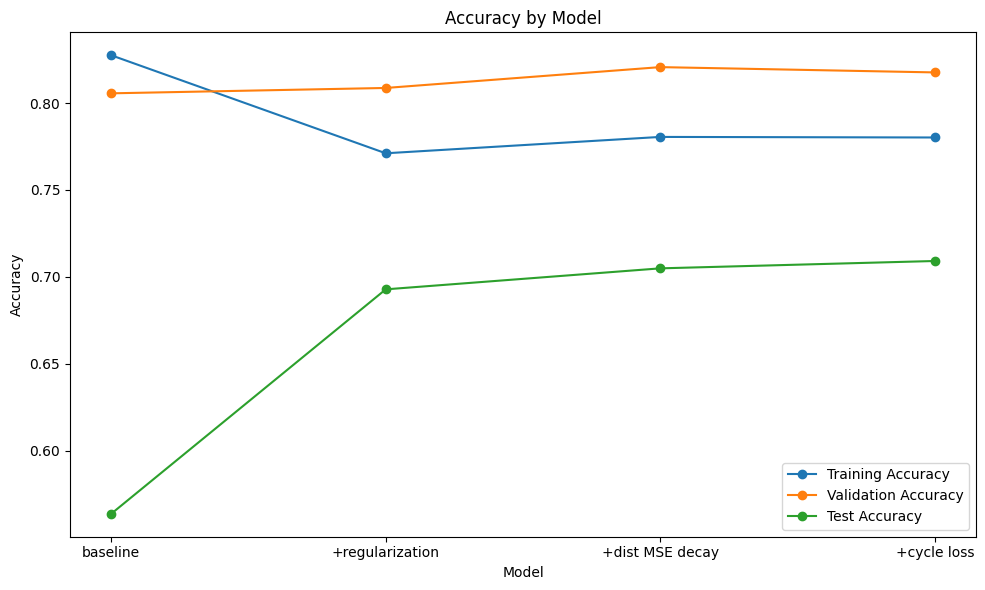

In [53]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


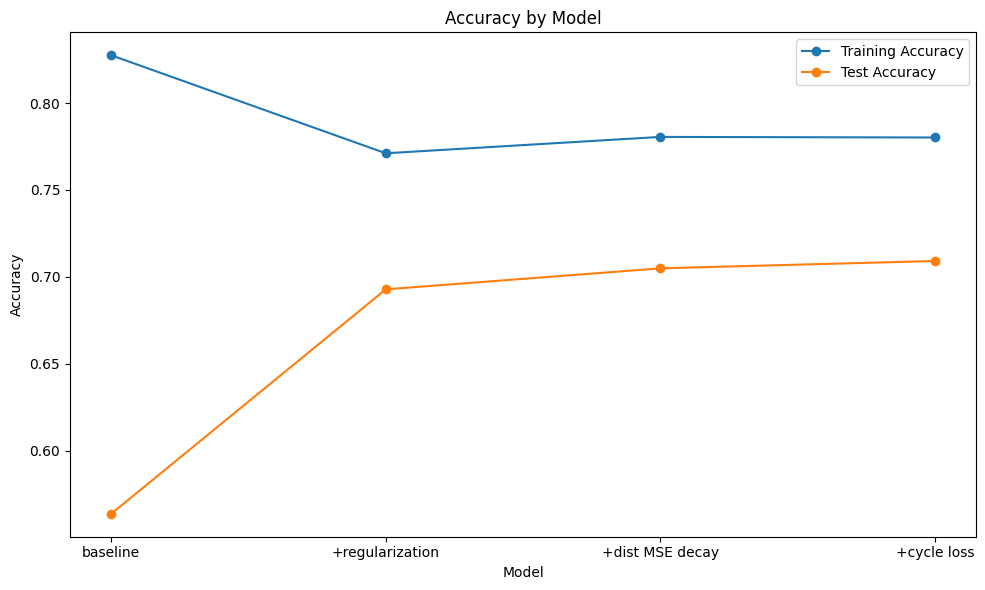

In [54]:
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df['Name'], res_df['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
# ax.plot(res_df['Name'], res_df['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df['Name'], res_df['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
res_dict = {}
for res in res_list:
    res_dict[res['name']] = res

In [56]:
res_baseline = res_dict['baseline']
ptruetrain = res_baseline['plots']['phate_true_train'] # baseline
ptrain = res_baseline['plots']['phate_pred_train'] # baseline
ctrain = res_baseline['plots']['colors_train']
ptruetest = res_baseline['plots']['phate_true']
ptest = res_baseline['plots']['phate_pred']
ctest = res_baseline['plots']['colors']

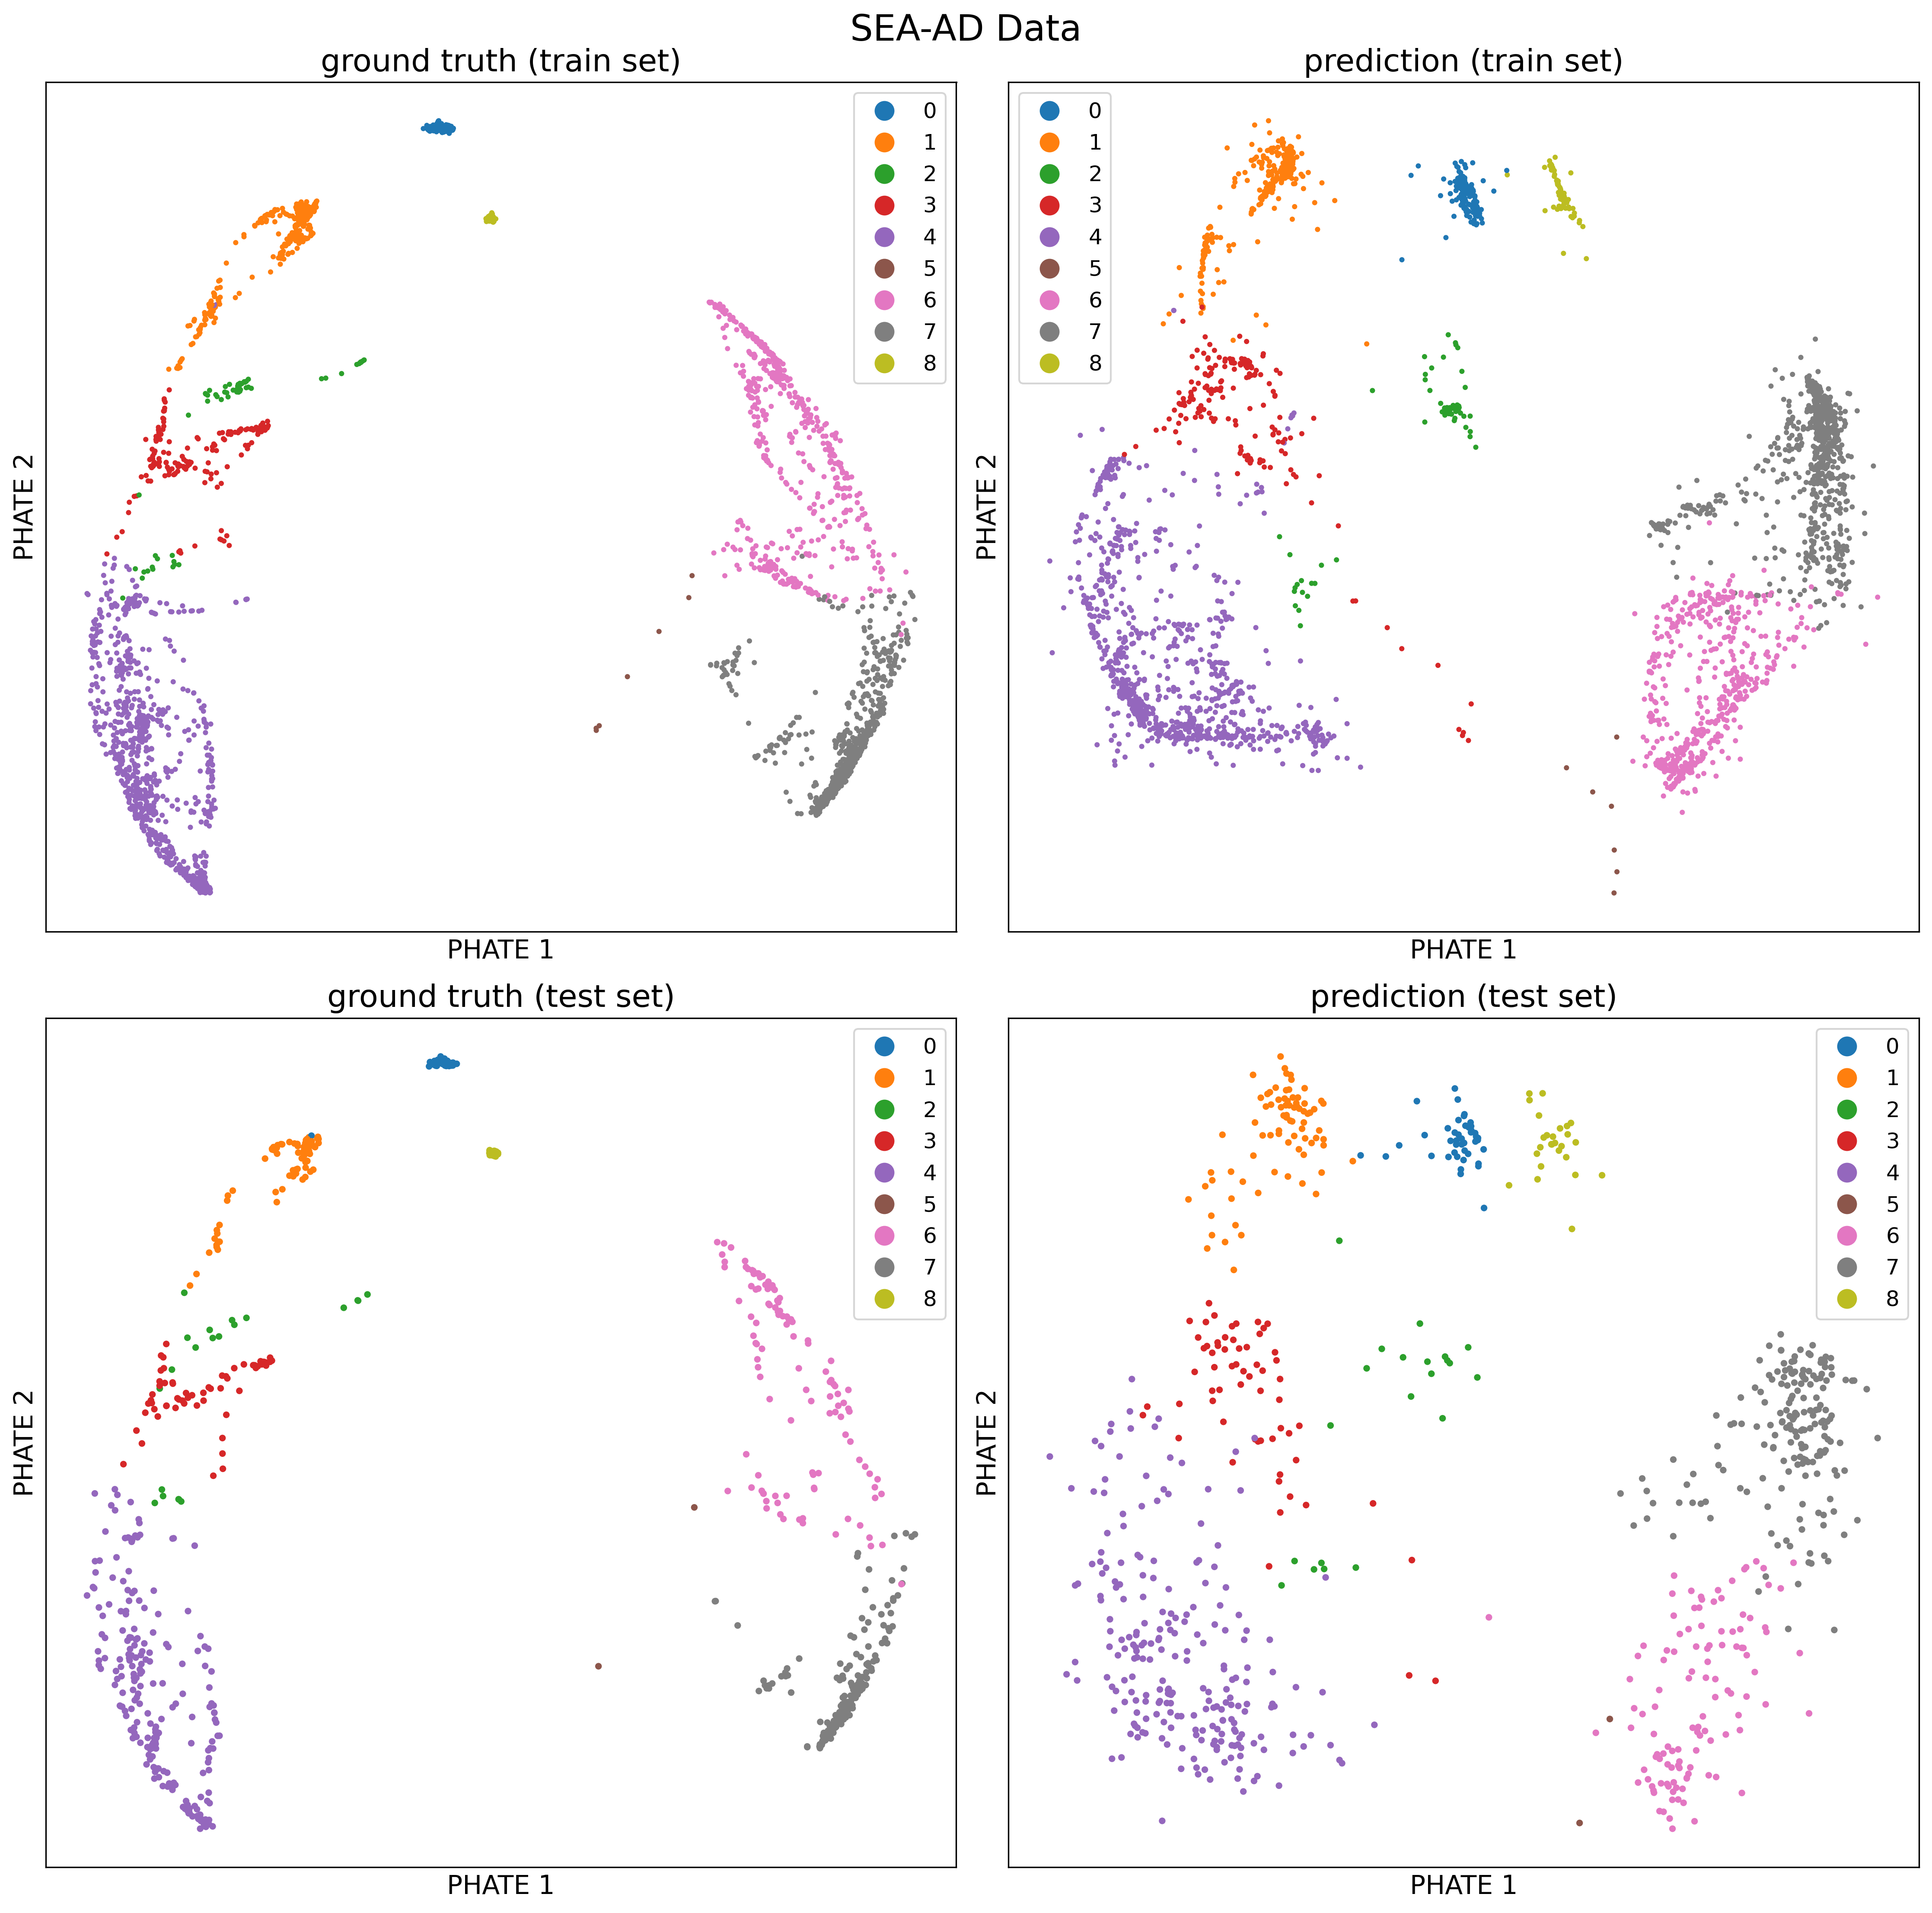

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(15,15), dpi=300)
scprep.plot.scatter2d(ptruetrain, c=ctrain, ax=axes[0,0], ticks=False, label_prefix="PHATE ", title='ground truth (train set)')
scprep.plot.scatter2d(ptrain, c=ctrain, ax=axes[0,1], ticks=False, label_prefix="PHATE ", title='prediction (train set)')
scprep.plot.scatter2d(ptruetest, c=ctest, ax=axes[1,0], ticks=False, label_prefix="PHATE ", title='ground truth (test set)')
scprep.plot.scatter2d(ptest, c=ctest, ax=axes[1,1], ticks=False, label_prefix="PHATE ", title='prediction (test set)')
plt.suptitle(f"SEA-AD Data", fontsize=20)
plt.tight_layout()
plt.show()

In [58]:
res_list[0]['plots'].keys()

dict_keys(['phate_true', 'phate_pred', 'colors', 'colors_train', 'dist_true_test_test', 'dist_pred_test_test', 'dist_true_test_train', 'dist_pred_test_train', 'phate_true_train', 'phate_pred_train', 'dist_true_train_train', 'dist_pred_train_train'])

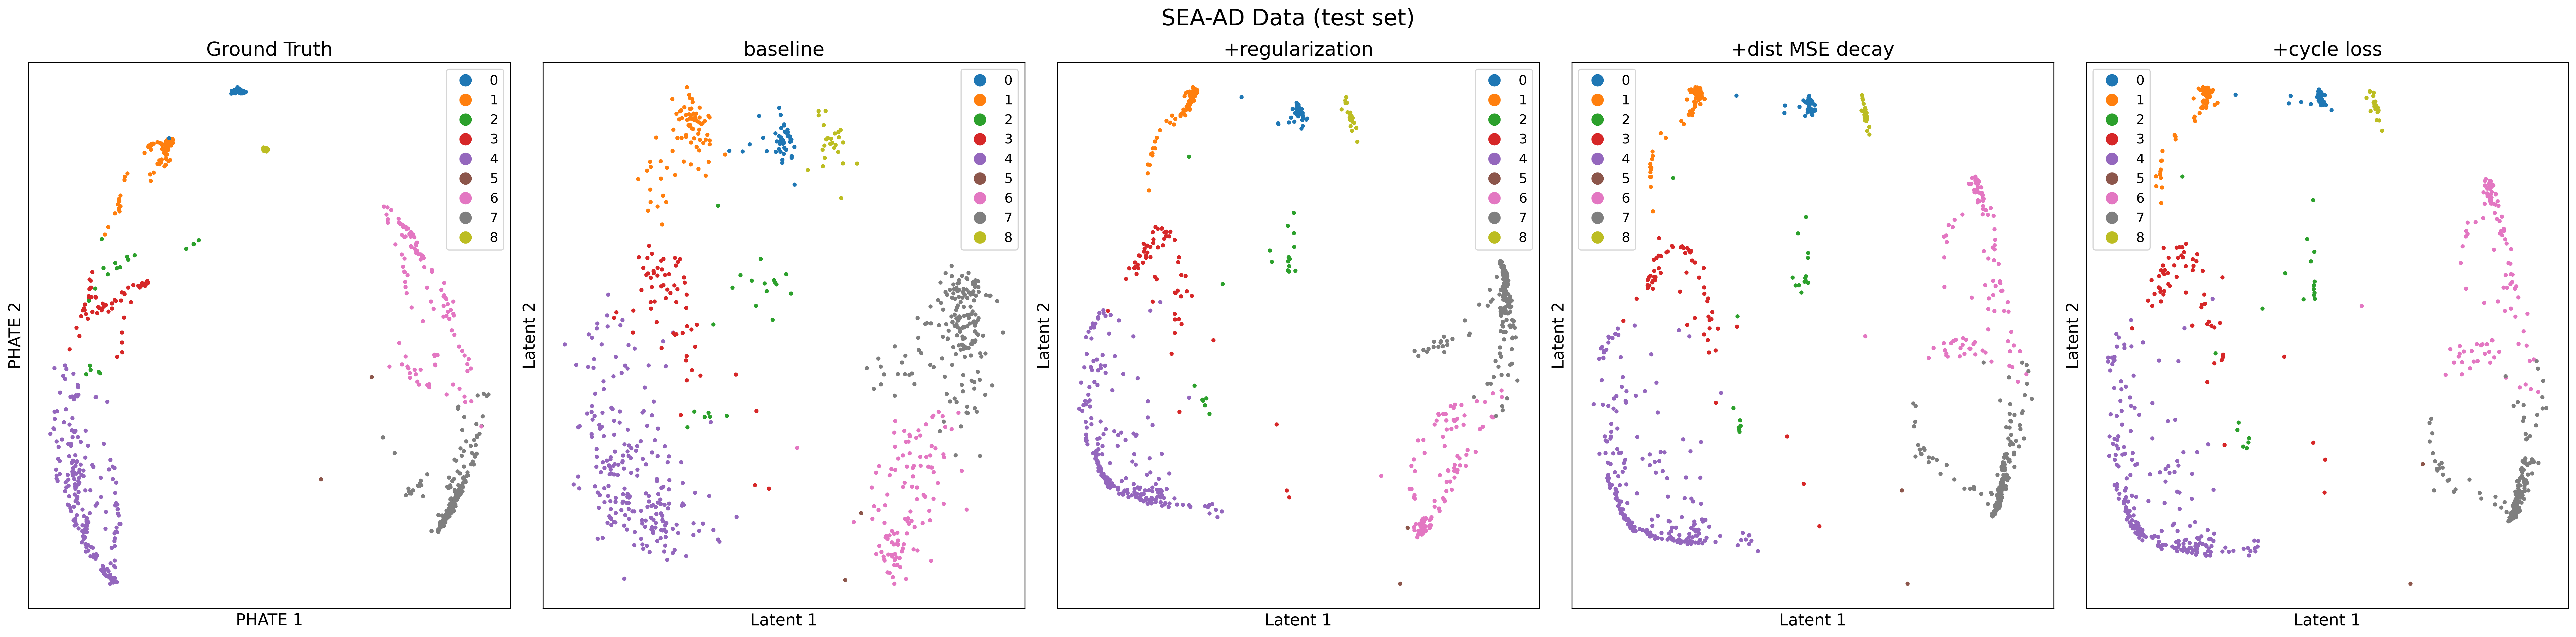

In [59]:
fig, axes = plt.subplots(1, len(res_dict)+1, figsize=(len(res_dict) * 8, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

res = res_dict['baseline']
scprep.plot.scatter2d(res['plots']['phate_true'], c=res['plots']['colors'], ax=axes[0], ticks=False, label_prefix="PHATE ", title='Ground Truth')

for i, name in enumerate(res_df['Name']):
    ax = axes[i+1]
    res = res_dict[name]
    scprep.plot.scatter2d(res['plots']['phate_pred'], c=res['plots']['colors'], ax=axes[i+1], ticks=False, label_prefix="Latent ", title=name)
plt.suptitle(f"SEA-AD Data (test set)", fontsize=20)
plt.tight_layout()
plt.show()

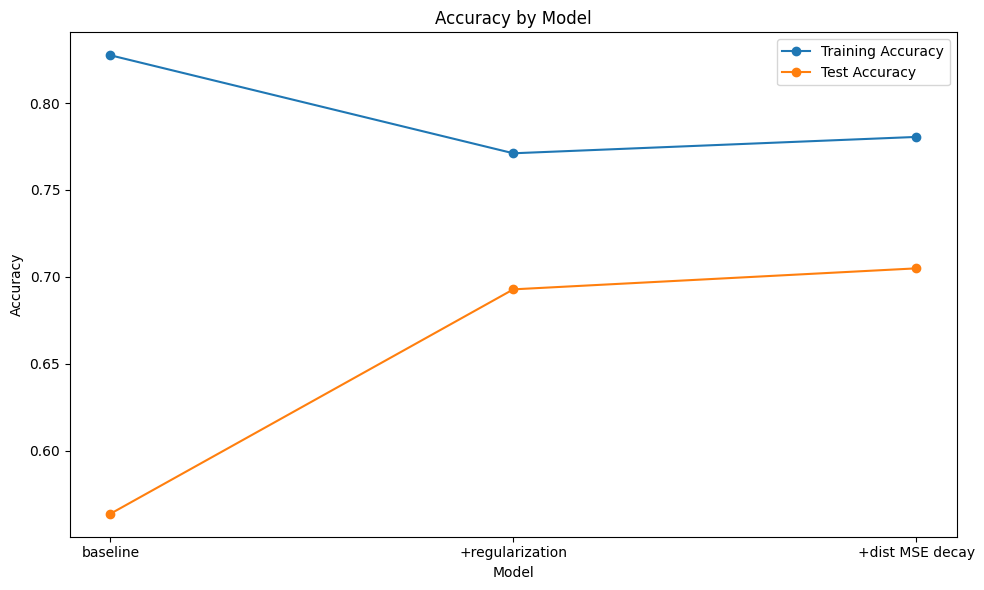

In [60]:
res_df2 = res_df[res_df['Name'] != '+cycle loss']
# Creating line plots with dots for Training and Validation Accuracy
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
ax.plot(res_df2['Name'], res_df2['Training Accuracy'], marker='o', label='Training Accuracy', linestyle='-')
# ax.plot(res_df2['Name'], res_df2['Validation Accuracy'], marker='o', label='Validation Accuracy', linestyle='-')
ax.plot(res_df2['Name'], res_df2['Test Accuracy'], marker='o', label='Test Accuracy', linestyle='-')

ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Model')
ax.legend()

# plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


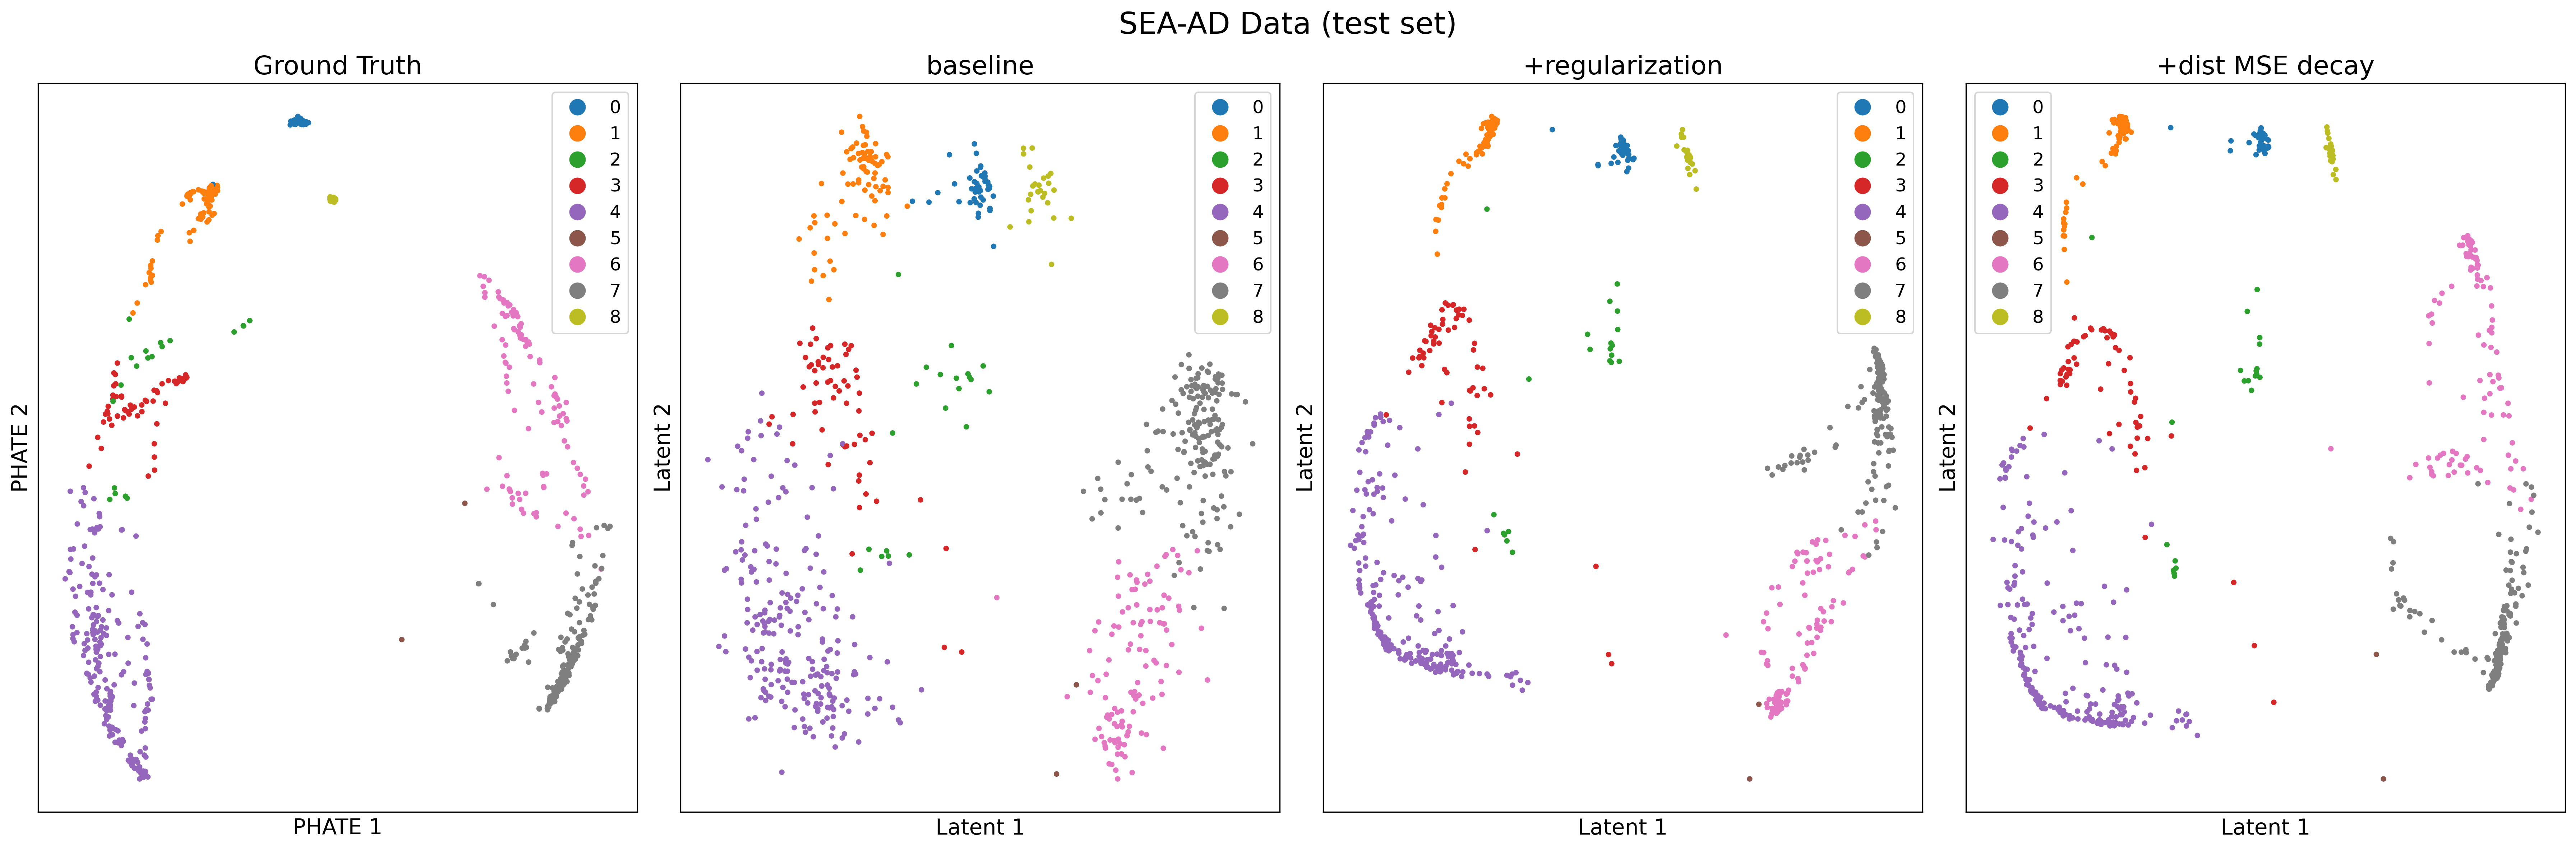

In [61]:
res_dict2 = {name: res_dict[name] for name in res_dict.keys() if name != '+cycle loss'}
fig, axes = plt.subplots(1, len(res_dict2)+1, figsize=(len(res_dict2) * 8, 8), dpi=300)  # Modify the number of subplots to 3, adjust the figsize, and set dpi to 300

res = res_dict2['baseline']
scprep.plot.scatter2d(res['plots']['phate_true'], c=res['plots']['colors'], ax=axes[0], ticks=False, label_prefix="PHATE ", title='Ground Truth')

for i, name in enumerate(res_df2['Name']):
    ax = axes[i+1]
    res = res_dict2[name]
    scprep.plot.scatter2d(res['plots']['phate_pred'], c=res['plots']['colors'], ax=axes[i+1], ticks=False, label_prefix="Latent ", title=name)
plt.suptitle(f"SEA-AD Data (test set)", fontsize=20)
plt.tight_layout()
plt.show()